In [25]:
import torch
import numpy as np
import cv2
from PIL import Image
from markdown_it.rules_inline import image
from seaborn import histplot
from transformers import SamProcessor, SamModel
from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import display 
from matplotlib import pyplot as plt
from utils import pic2float, pic2int, pic2pil, sigmoid, swimg

# MODEL_NAME = "facebook/sam-vit-base"
# MODEL_NAME = "facebook/sam-vit-large"
# MODEL_NAME = "facebook/sam-vit-huge"
# DTYPE = torch.float16

In [2]:
def advanced_mask(logits, threshold=0.5, sigma=5, alpha=10):
    """
    Создает сложную маску с чёткими внутренними объектами и мягкими границами.
    
    :param logits: Логиты (numpy массив)
    :param threshold: Порог для бинаризации
    :param sigma: Параметр размытия для сглаживания границ
    :param alpha: Коэффициент крутизны для сигмоиды
    :return: Маска с плавными границами (numpy массив)
    """
    # 1. Бинаризация логитов
    sigmoid = 1 / (1 + np.exp(-logits))  # Преобразуем логиты в вероятности
    binary_mask = (sigmoid >= threshold).astype(np.float32)  # Бинарная маска

    # 2. Размытие бинарной маски для выделения границ
    blurred_binary = cv2.GaussianBlur(binary_mask, (0, 0), sigma)    

    # Нормализация размытой маски (для диапазона 0-1)
    blurred_binary = 0.25 - (blurred_binary - 0.5) ** 2 
    blurred_binary = cv2.GaussianBlur(blurred_binary, (0, 0), sigma)
    
    
    blurred_binary = blurred_binary / np.max(blurred_binary)
    blurred_binary = np.clip(blurred_binary, 0, 1)
    # print(blurred_binary.max(), blurred_binary.min())
    
    
    # return blurred_binary
    # 3. Применение размытой маски к сигмоиде
    alpha = 4
    soft_mask = 1 / (1 + np.exp(-alpha * (sigmoid - threshold)))  # Сигмоидная маска
    soft_mask = 1 * (sigmoid - 0.5) + 0.5 
    
    # binary_mask = cv2.GaussianBlur(binary_mask, (0, 0), 1)
    
    final_mask = soft_mask * blurred_binary + binary_mask * (1 - blurred_binary)
    final_mask = np.clip(final_mask, 0, 1)

    return final_mask

def mask_crop(image, mask):
    coords = np.where(mask)
    y_min, y_max = coords[0].min(), coords[0].max()
    x_min, x_max = coords[1].min(), coords[1].max()
    return image[y_min:y_max, x_min:x_max], mask[y_min:y_max, x_min:x_max]

def center(image, mask, shape = (512, 512), boudary = 0.2):
    h, w = shape
    bh = int(h * (1-boudary))
    bw = int(w * (1-boudary))
    obj_h, obj_w, _ = image.shape
    scale = min(bh / obj_h, bw / obj_w)
    new_h, new_w = int(obj_h * scale), int(obj_w * scale)
    # display(pic2pil(image))
    if scale < 1:
        algo = cv2.INTER_AREA
    else:
        algo = cv2.INTER_AREA
        algo = cv2.INTER_LINEAR 
        # algo = cv2.INTER_CUBIC
        # algo = cv2.INTER_LANCZOS4
    
    image = cv2.resize(image, (new_w, new_h), interpolation=algo)
    
    mask = cv2.resize(mask, (new_w, new_h))
    
    top = (h - new_h) // 2
    left = (w - new_w) // 2
    
    new_mask = np.zeros((h, w, 3), dtype=np.float32)
    new_mask[top:top+new_h, left:left+new_w] = mask
    # 
    new_image = np.zeros((h, w, 3), dtype=np.float32)
    new_image[top:top+new_h, left:left+new_w] = image
        
    return new_image, new_mask
    # return image, mask
    

In [3]:
model = SamModel.from_pretrained(MODEL_NAME).to()

In [5]:
class Predictor():
    def __init__(self, model=None, processor=None, device=None, model_name=MODEL_NAME, type=DTYPE):
        self.dtype = type

        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = device

        if model is None:
            model = SamModel.from_pretrained(model_name).to(self.dtype).to(self.device)
        if processor is None:
            processor = SamProcessor.from_pretrained(MODEL_NAME)

        self.model = model.to(self.device)
        self.processor = processor

    def predict(self, image, input_points=None):
        image = pic2float(image)

        if input_points is None:
            input_points = [[[image.shape[1] // 2, image.shape[0] // 2]]]

        inputs = self.processor(image, input_points=input_points, return_tensors="pt", do_rescale=False).to(self.dtype).to("cuda")

        with torch.inference_mode():
            outputs = self.model(**inputs)

        scores = outputs.iou_scores[0][0].cpu().detach().numpy().astype('float')
        masks = self.processor.image_processor.post_process_masks(
            outputs.pred_masks.cpu(),
            inputs["original_sizes"].cpu(),
            inputs["reshaped_input_sizes"].cpu(),
            binarize=False
        )[0][0].cpu().numpy().astype('float')

        return scores, masks

    @staticmethod
    def best_masks(scores, masks, n=4):

        best_masks = []
        best_masks_indexex = np.argsort(scores)[::-1][:n]

        for idx in best_masks_indexex:
            
            mask, score = masks[idx], scores[idx]
            mask = advanced_mask(mask)
            mask = np.stack([mask, mask, mask], axis=-1)
            best_masks.append(mask)
        return best_masks


In [14]:
#очистка видеопамяти
torch.cuda.empty_cache()

# сборщик мусора
import gc
gc.collect()

1060

In [6]:
sam_predictor = Predictor()

def sam_process(image, text=None):

    scores, masks = sam_predictor.predict(image)
    masks = sam_predictor.best_masks(scores, masks, 4)

    composes = []
    crop_masks = []

    for mask in masks:
        temp_image = image.copy()
        temp_image, mask = mask_crop(temp_image, mask)
        temp_image, mask = center(temp_image, mask)
        bg = np.ones_like(temp_image)
        compose = temp_image * mask + (1 - mask) * bg

        composes.append(compose)
        crop_masks.append(mask)
        
    return composes, crop_masks, text

In [1]:
from utils import pic2float, pic2int, pic2pil, pic2tensor, sigmoid, swimg
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from transformers import AutoModelForImageSegmentation, BitsAndBytesConfig


In [26]:
# Load BiRefNet with weights


quant_config = BitsAndBytesConfig(
            load_in_4bit=True,  # включаем 4-битную квантизацию
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=False,
            bnb_4bit_quant_type="nf4"  # можно попробовать и другие варианты, например 'fp4'
        )


birefnet = AutoModelForImageSegmentation.from_pretrained(
    'ZhengPeng7/BiRefNet', 
    trust_remote_code=True,
    torch_dtype=torch.float16,
    quantization_config=quant_config
).to('cuda').eval()

torch.set_float32_matmul_precision(['high', 'highest'][0])

`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [ ]:
quant_config = BitsAndBytesConfig(


In [3]:
# Imports


# from models.birefnet import BiRefNet

# birefnet = ... # -- BiRefNet should be loaded with codes above, either way.
# torch.set_float32_matmul_precision(['high', 'highest'][0])
birefnet.to('cuda')
birefnet.eval()
1

1

In [2]:
test_image = "../image.jpg"
test_image = Image.open(test_image).convert("RGB")

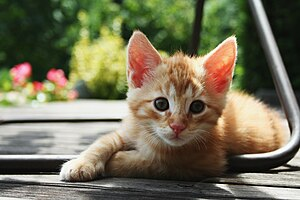

In [8]:
test_image

(1024, 1024)
(300, 200)


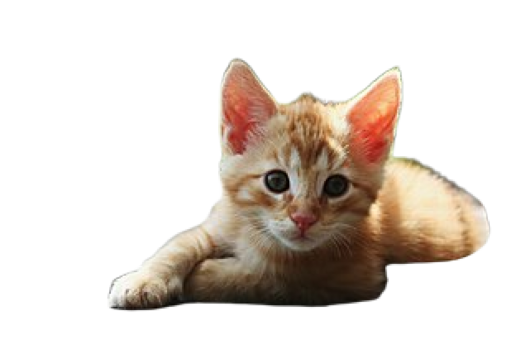

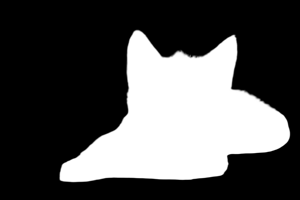

In [53]:
def extract_object(birefnet, image):
    image = image.copy()
    # Data settings
    image_size = (1024, 1024)
    image = pic2float(image)
    orgn_size = image.shape[:2]

    # image = pic2tensor(image).to('cuda')
    
    transform_image = transforms.Compose([
        transforms.ToTensor(),        
        transforms.Resize(image_size),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # image = image.copy()
    input_images = transform_image(image).to(torch.float16).unsqueeze(0).to('cuda')

    # Prediction
    with torch.no_grad():
        preds = birefnet(input_images)[-1].sigmoid().cpu()
    pred = preds[0].squeeze()
    pred_pil = transforms.ToPILImage()(pred)
    print(pred_pil.size)
    mask = pred_pil.resize(orgn_size[::-1])
    image = pic2pil(image)
    print(mask.size)
    # print(image.size)
    image.putalpha(mask)
    return image, mask, preds

image_alpha, mask, pred_pil = extract_object(birefnet, image=test_image)

# Visualization
plt.axis("off")
plt.imshow(image_alpha)
plt.show()

mask

In [45]:
pred_pil.squeeze().shape

torch.Size([1024, 1024])

In [ ]:
a = pic2float(test_image)
a = pic2float(a)
a

In [38]:

a = np.array(image_alpha)
a.shape

(200, 300, 4)

In [3]:
MODEL_NAME = 'ZhengPeng7/BiRefNet'
DTYPE = torch.float16
class BiRef_Predictor():
    def __init__(self, model=None, processor=None, device=None, model_name=MODEL_NAME, type=DTYPE):
        self.dtype = type

        quant_config = BitsAndBytesConfig(
            load_in_4bit=True,  # включаем 4-битную квантизацию
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=False,
            bnb_4bit_quant_type="nf4"  # можно попробовать и другие варианты, например 'fp4'
        )

        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = device

        if model is None:
            model = AutoModelForImageSegmentation.from_pretrained(
                model_name,
                trust_remote_code=True,
                torch_dtype=self.dtype,
                quantization_config=quant_config
            )

        self.model = model.to(self.device)
        self.processor = processor

        self.proc_size = (1024, 1024)
        self.processor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(self.proc_size),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def predict(self, image, sale_mask=False):
        image = pic2float(image)
        org_size = image.shape[:2]
        input = self.processor(image).to(self.dtype).unsqueeze(0).to("cuda")

        with torch.inference_mode():
            mask = self.model(input)[-1].sigmoid()

        if sale_mask:
            mask = transforms.Resize(org_size)(mask)

        return mask.squeeze().cpu().numpy()

In [4]:
pred = BiRef_Predictor()


N:\PROJECTS\python\STUDY\tg_pet_detector\tg_pet_detector_GUI\.venv\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
N:\PROJECTS\python\STUDY\tg_pet_detector\tg_pet_detector_GUI\.venv\Lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
`low_cpu_mem_usage` was None, now default to True since model is quantized.


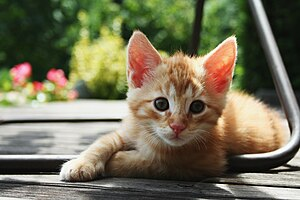

In [5]:
test_image

In [70]:
a = pred.predict(test_image)

In [72]:
a.shape

(1024, 1024)

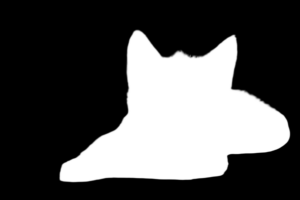

In [6]:
m = pred.predict(test_image, sale_mask=True)
a = pic2pil(m)
a

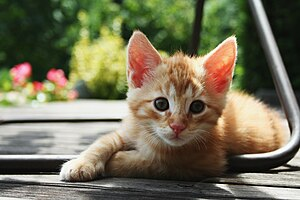

In [8]:
im = test_image
im

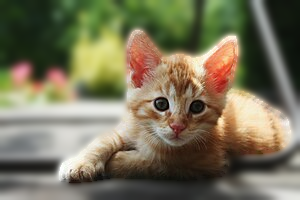

In [132]:
import cv2
import seaborn as sns
from matplotlib import pyplot as plt

def dec(im, mask, steps=5, blur=3):
    im  = pic2float(im)    
    mask = pic2float(mask)
    
    if len(mask.shape) == 2:
        mask = np.stack([mask, mask, mask], axis=-1)
        
    hm1 = (mask>0.999).astype(np.float32)

    im_un = im
    
    for _ in range(steps):    
        im_un = mask_blur(im_un, hm1, blur)
    #im = im_un*hm0 + im*(1-hm0)
    
    return im_un

def ummult(im, m):
    # im = pic2float(im)
    # m = pic2float(m)    
    e = 0.00001
    return im / (m + e)

def mask_blur(im,m,b=3):

    # black = np.zeros_like(im)    
    im_m = im * m
    im_m = cv2.GaussianBlur(im_m, (b, b), 0)
    im_b = cv2.GaussianBlur(im, (b, b), 0)
    mb = cv2.GaussianBlur(m, (b, b), 0)
    im_un = ummult(im_m, mb)
    hmb0 = mb > 0.001    
    im_b = hmb0 * im_un + (1-hmb0) * im_b
    
    im = im * m + (1-m) * im_b    

    return im

a = dec(im, m, steps=15, blur=5)    


# sns.histplot(a.reshape(-1))

plt.show()
pic2pil(a)

In [ ]:

pic2pil(a)

In [134]:
import time

round(time.time(),2)

1738095278.49

In [124]:
# Imports
from PIL import Image
import torch
from torchvision import transforms
from IPython.display import display

# from models.birefnet import BiRefNet


# Load Model
device = 'cuda'
torch.set_float32_matmul_precision(['high', 'highest'][0])
# model = BiRefNet.from_pretrained('zhengpeng7/birefnet')
model = AutoModelForImageSegmentation.from_pretrained('ZhengPeng7/BiRefNet', trust_remote_code=True)
model.to(device)
model.eval()
print('BiRefNet is ready to use.')

# Input Data
transform_image = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
imagepath = '../image.jpg'
def pred_and_show(imagepath=imagepath, box=[-1, -1, -1, -1]):
    # box: left, top, right, bottom
    image = Image.open(imagepath)
    w, h = image.size[:2]
    for idx_coord_value, coord_value in enumerate(box):
        if coord_value == -1:
            box[idx_coord_value] = [0, 0, w, h][idx_coord_value]
    image_crop = image.crop(box)
    input_images = transform_image(image_crop).unsqueeze(0).to('cuda')

    # Prediction
    with torch.no_grad():
        preds = model(input_images)[-1].sigmoid().cpu()
    pred = preds[0].squeeze()

    canvas = torch.zeros_like(pred)
    box_to_canvas = [int(round(coord_value * (canvas.shape[-1] / w, canvas.shape[-2] / h)[idx_coord_value % 2])) for idx_coord_value, coord_value in enumerate(box)]
    pred = torch.nn.functional.interpolate(
        pred.unsqueeze(0).unsqueeze(0),
        size=(box_to_canvas[3] - box_to_canvas[1], box_to_canvas[2] - box_to_canvas[0]),
        mode='bilinear',
        align_corners=True
    ).squeeze()
    canvas[box_to_canvas[1]:box_to_canvas[3], box_to_canvas[0]:box_to_canvas[2]] = pred

    # Show Results
    pred_pil = transforms.ToPILImage()(canvas)
    # Scale proportionally with max length to 1024 for faster showing
    scale_ratio = 1024 / max(image.size)
    scaled_size = (int(image.size[0] * scale_ratio), int(image.size[1] * scale_ratio))
    image_masked = image.resize((1024, 1024))
    image_masked.putalpha(pred_pil)
    display(image_masked.resize(scaled_size))
    display(image.resize(scaled_size))
    display(pred_pil.resize(scaled_size))
    return pred_pil

pred_pil = pred_and_show(box=[666, 250, 1100, 777])

BiRefNet is ready to use.


RuntimeError: The expanded size of the tensor (0) must match the existing size (1482) at non-singleton dimension 1.  Target sizes: [0, 0].  Tensor sizes: [2698, 1482]

In [1]:
import pandas as pd
from seaborn import histplot

from ML_SERVER.birefnet import biref_process
from utils import pic2float, pic2int, pic2pil, sigmoid, swimg, mask_crop, memo, center, memo

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms as tt
from torchvision.transforms import v2
from torchvision.transforms import functional as tf

# dataset
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from IPython.display import clear_output

import plotly.express as px

import kornia
from constant import device, ROOT

N:\PROJECTS\python\STUDY\tg_pet_detector\tg_pet_detector_GUI\.venv\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
N:\PROJECTS\python\STUDY\tg_pet_detector\tg_pet_detector_GUI\.venv\Lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [3]:
image_path = os.path.join(ROOT, "image.jpg")
image = Image.open(image_path)
image = pic2float(image)

In [4]:
image, mask = biref_process(image)
# mask = mask[:,:,None]
print(image.shape, mask.shape)

(200, 300, 3) (1024, 1024, 3)


In [6]:
import cv2

In [18]:
new_w, new_h = image.shape[:2]
cv2.resize(np.array(mask, dtype=np.float32), (new_w*2, new_h//2))

array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [7.2977542e-07, 7.2977542e-07, 7.2977542e-07],
        [2.2984743e-06, 2.2984743e-06, 2.2984743e-06],
        ...,
        [1.5515486e-06, 1.5515486e-06, 1.5515486e-06],
        [1.0484775e-06, 1.0484775e-06, 1.0484775e-06],
        [1.5836159e-06, 1.5836159e-06, 1.5836159e-06]],

       [[4.3647287e-07, 4.3647287e-07, 4.3647287e-07],
        [3.1760453e-06, 3.1760453e-06, 3.1760453e-06],
        [6.2874556e-06, 6.2874556e-06, 6.2874556e-06],
        ...,
        [1.1674881e-05, 1.1674881e-05, 1.1674881e-05],
        [6.7119122e-06, 6.7119122e-06, 6.7119122e-06],
        [4.1106464e-06, 4.1106464e-06, 4.1106464e-06]],

       [[5.1736833e-07, 5.1736833e-07, 5.1736833e-07],
        [3.4550428e-06, 3.4550428e-06, 3.4550428e-06],
        [6.7001583e-06, 6.7001583e-06, 6.7001583e-06],
        ...,
        [9.8315877e-06, 9.8315877e-06, 9.8315877e-06],
        [4.6225787e-06, 4.6225787e-06, 4.6225787e-06],
        [2.2668441e-06

In [19]:
import numpy as np

params = {'rot':'45'}

params.get('text', 0)


0